In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage import exposure
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error
from scipy.stats import entropy as scipy_entropy
from concurrent.futures import ThreadPoolExecutor, as_completed


def enhance_image(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(img)
    gamma = 1.2
    enhanced = np.array(255 * (enhanced / 255.0) ** gamma, dtype=np.uint8)
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    sharpened = cv2.addWeighted(enhanced, 1.5, blurred, -0.5, 0)
    return sharpened


def compute_metrics(original, processed):
    metrics = {}
    metrics['SSIM'] = structural_similarity(original, processed, data_range=255)
    metrics['PSNR'] = peak_signal_noise_ratio(original, processed, data_range=255)
    metrics['MSE'] = mean_squared_error(original, processed)
    hist, _ = np.histogram(processed.flatten(), bins=256, range=(0, 255), density=True)
    metrics['Entropy'] = scipy_entropy(hist + 1e-8)
    noise = original.astype(np.float32) - processed.astype(np.float32)
    metrics['SNR'] = 10 * np.log10(np.sum(original ** 2) / (np.sum(noise ** 2) + 1e-8))
    metrics['CC'] = np.corrcoef(original.flatten(), processed.flatten())[0, 1]
    return metrics


def process_image(img_path, save_dir):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    enhanced = enhance_image(img)
    metrics = compute_metrics(img, enhanced)

    save_path = os.path.join(save_dir, os.path.basename(img_path))
    cv2.imwrite(save_path, enhanced)
    return os.path.basename(img_path), metrics


def process_all(input_dir, output_dir, max_workers=8):
    os.makedirs(output_dir, exist_ok=True)
    image_paths = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                   if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    records = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_image, path, output_dir) for path in image_paths]
        for f in as_completed(futures):
            result = f.result()
            if result:
                name, metrics = result
                records.append({"Filename": name, **metrics})

    df = pd.DataFrame(records)
    df.to_excel(r"C:\Users\Charlotte\Desktop\dissertation\US_new\enhancement_metrics.xlsx", index=False)
    print(f"Finished processing, total {len(df)} graphs. The metrics are saved to enhancement_metrics.xlsx.")


if __name__ == "__main__":
    input_dir = r"C:\Users\Charlotte\Desktop\dissertation\US_new\All_Images"
    output_dir = r"C:\Users\Charlotte\Desktop\dissertation\US_new\All_Enhanced"
    process_all(input_dir, output_dir)

Finished processing, total 1424 graphs. The metrics are saved to enhancement_metrics.xlsx.


Metrics were computed and saved as enhancement_summary.xlsx


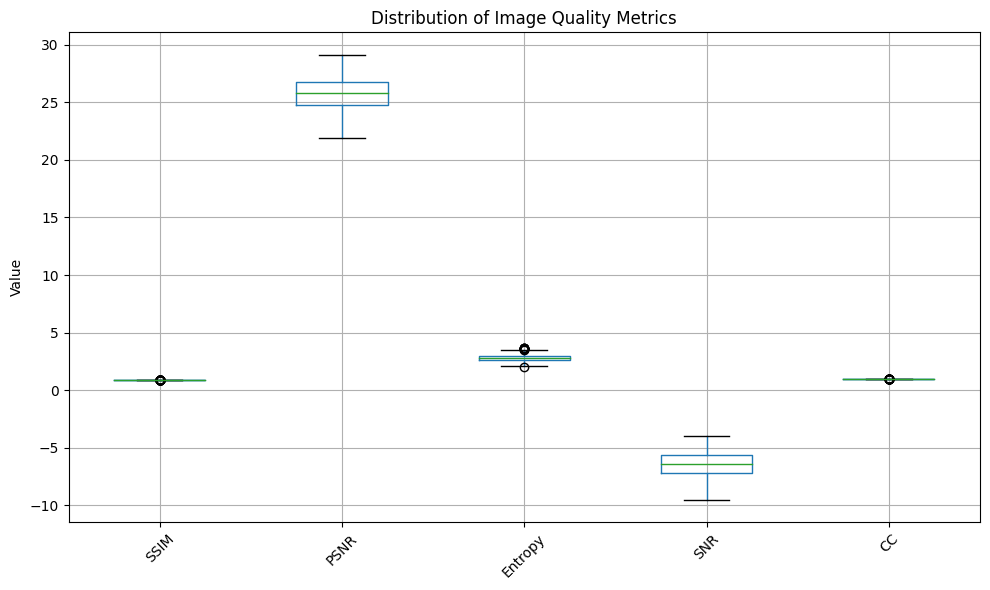

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt

metrics_path = r"C:\Users\Charlotte\Desktop\dissertation\US_new\enhancement_metrics.xlsx"
output_dir = os.path.dirname(metrics_path)

df = pd.read_excel(metrics_path)

df["Patient"] = df["Filename"].str.extract(r"(Abbey\s?\d+|[A-Za-z]+\s?\d+)", expand=False).str.replace(" ", "")
df["Stage"] = df["Filename"].str.extract(r"(v\d+)", expand=False)

summary_all = df.describe().T
summary_all["Metric"] = summary_all.index
summary_all = summary_all[["Metric", "mean", "std", "min", "max"]]

summary_by_patient = (
    df.groupby("Patient")[["SSIM", "PSNR", "MSE", "Entropy", "SNR", "CC"]]
    .mean()
    .reset_index()
)

with pd.ExcelWriter(os.path.join(output_dir, "enhancement_summary.xlsx")) as writer:
    summary_all.to_excel(writer, sheet_name="Overall_Stats", index=False)
    summary_by_patient.to_excel(writer, sheet_name="By_Patient", index=False)

print("Metrics were computed and saved as enhancement_summary.xlsx")

plt.figure(figsize=(10, 6))
df.boxplot(column=["SSIM", "PSNR", "Entropy", "SNR", "CC"])
plt.title("Distribution of Image Quality Metrics")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig(os.path.join(output_dir, "metrics_distribution.png"), dpi=300)
plt.show()

In [4]:
import os
import shutil
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

excel_path = r"C:\Users\Charlotte\Desktop\dissertation\US_new\enhancement_metrics.xlsx"
image_dir = r"C:\Users\Charlotte\Desktop\dissertation\US_new\All_Enhanced"
save_dir = r"C:\Users\Charlotte\Desktop\dissertation\US_new"

df = pd.read_excel(excel_path)

metrics_cols = ["SSIM", "PSNR", "Entropy", "SNR", "CC"]
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df[metrics_cols]),
    columns=metrics_cols
)

df_scaled["score"] = (
    0.25 * df_scaled["SSIM"] +
    0.25 * df_scaled["PSNR"] +
    0.2  * df_scaled["Entropy"] +
    0.15 * df_scaled["SNR"] +
    0.15 * df_scaled["CC"]
)

df_scaled["Filename"] = df["Filename"]
df_top = df_scaled[df_scaled["score"] > 0.5].sort_values("score", ascending=False)

os.makedirs(save_dir, exist_ok=True)
save_excel = os.path.join(save_dir, "top_quality_images.xlsx")
df_top.to_excel(save_excel, index=False)
print(f"List of {len(df_top)} high-quality images saved to {save_excel}")

high_quality_dir = os.path.join(save_dir, "High_quality_images")
os.makedirs(high_quality_dir, exist_ok=True)

for filename in df_top["Filename"]:
    src = os.path.join(image_dir, filename)
    dst = os.path.join(high_quality_dir, filename)
    if os.path.exists(src):
        shutil.copy(src, dst)

print(f"Copy {len(df_top)} high-quality images to {high_quality_dir}")

List of 1181 high-quality images saved to C:\Users\Charlotte\Desktop\dissertation\US_new\top_quality_images.xlsx
Copy 1181 high-quality images to C:\Users\Charlotte\Desktop\dissertation\US_new\High_quality_images
